Notebook for the study of normalization techniques with deep learning models.

In [1]:
import pandas as pd 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np 
from keras.utils import pad_sequences
import os 

# Data normalization 
from pandas import Series 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout


In [2]:
df_trajectory = pd.read_csv('TLRDGTUSTUAEMAIIHFFEDNTSL_20221201_ContextId_5_TrackId_118690_2022-12-01_13-43_NotAvailable.csv')
df_trajectory.head()

,ID,DeviceID,ContextID,DeviceTrackID,ScenarioTrackID,ScenarioTimeStamp,LockedID,ScanNumber,ScenarioCoordinate1,ScenarioCoordinate2,...,AngularSize,Detections,Power,Clutter,Doppler,Rcs,Type,UpdateType,LifeTime,ActiveTime
0,118690,18,5,23974,118690,1.669902e+09,0,11169,-1.633530,42.246939,...,5,5,415.142822,157.428574,0.0,0,Unknown,Gain,5000,0.0
1,118690,18,5,23974,118690,1.669902e+09,0,11170,-1.633655,42.246800,...,5,5,415.142822,157.428574,0.0,0,Unknown,Update,5000,1.0
2,118690,18,5,23974,118690,1.669902e+09,0,11171,-1.633785,42.246648,...,4,4,246.285721,103.428574,0.0,0,Unknown,Update,5000,2.0
3,118690,18,5,23974,118690,1.669902e+09,0,11172,-1.633978,42.246536,...,6,11,1000.000000,389.714294,0.0,0,Unknown,Update,5000,3.0
4,118690,18,5,23974,118690,1.669902e+09,0,11173,-1.634286,42.246457,...,3,3,169.714294,90.428574,0.0,0,Unknown,Update,5000,4.0


0     1225.598787
1     1215.578189
2     1205.098727
3     1189.398682
4     1164.093333
         ...     
87     327.920127
88     321.077866
89     333.676295
90     330.944477
91     338.975331
Name: DeviceCoordinate1, Length: 92, dtype: float64


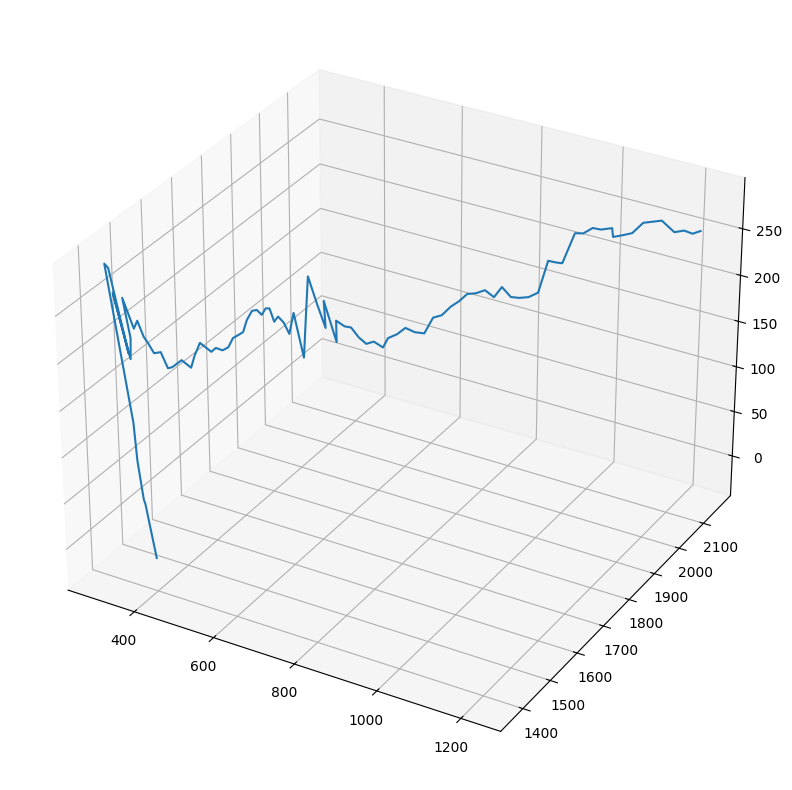

In [3]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
x = df_trajectory['DeviceCoordinate1']
y = df_trajectory['DeviceCoordinate2']
z = df_trajectory['DeviceCoordinate3']

ax.plot3D(x,y,z)

# plt.show()
print(x)

In [4]:
def Min_max_normalization(df_coordinate): 
    # Convert to a time series 
    df_series = Series(df_coordinate)

    # Take the values of the series 
    x_values = df_series.values
    x_values = x_values.reshape((len(x_values), 1))


    # Define the min max scaler
    x_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaler = x_scaler.fit(x_values)


    # Normalize the whole series 
    x_normalized = x_scaler.transform(x_values)

    return x_normalized 
     

def std_normalization(df_coordinate): 
    x_series_std = Series(df_coordinate)

    x_values_std = x_series_std.values

    x_values_std = x_values_std.reshape((len(x_values_std), 1))

    x_scaler_std = StandardScaler()

    x_scaler_std = x_scaler_std.fit(x_values_std)
    # print('Mean X: %f, StandardDeviation: %f' % (x_scaler_std.mean_, sqrt(x_scaler_std.var_)))

    # normalize the dataset and print
    x_standardized = x_scaler_std.transform(x_values_std)
    
    # print(x_standardized)

    return x_standardized

def prev_center_max_normalization(z,z1,D_max): 
    # z is the sequence of observations
    # z1 is the initial value of the sequence
    # D_max is the maximum distance the target can move within K time steps
    
    # Centering the sequence by subtracting z1 from every element
    centered_z = z - z1
    
    # Normalizing the sequence to the range [-1, 1]
    normalized_z = centered_z / D_max
    
    return normalized_z

def center_max_normalization(df_coordinate): 
    x_series_center_max = Series(df_coordinate)

    x_values_center_max = x_series_center_max.values

    # Apply the center max normalization to x values 
    x_normalized_data_center_max = np.empty(x_values_center_max.shape)
    x_1 = x_values_center_max[0]
    dmax_x = np.max(np.abs(x_values_center_max-x_1))
    for i in range(len(x_series_center_max)): 
        x_normalized_data_center_max[i] = prev_center_max_normalization(x_values_center_max[i],x_1,dmax_x)

    return  x_normalized_data_center_max

# Data processing

In [5]:
#There should be two directories: Bird and Drone. Each subdirectory will contain multiple csv files
base_path_bird = 'Bird'  # Base directory

#set fixed length
fixed_length = 100

#choose columns 
columns_to_keep = ['ID', 'DeviceCoordinate1', 'DeviceCoordinate2']


index_bird= 0 
mean_len_list_bird = []

all_bird_trajectories_min_max= pd.DataFrame()
all_bird_trajectories_std= pd.DataFrame()
all_bird_trajectories_center_max = pd.DataFrame()

for date_folder in os.listdir(base_path_bird):
    date_folder_path = os.path.join(base_path_bird, date_folder)
    if os.path.isdir(date_folder_path):
        for csv_file in os.listdir(date_folder_path):
            if csv_file.endswith('.csv'):
                file_path = os.path.join(date_folder_path, csv_file)
                temp_df = pd.read_csv(file_path)
                temp_df = temp_df[columns_to_keep]

                if(len(temp_df) < 20): # Si la trayectoria tiene menos de 20 puntos la eliminamos 
                    index_bird = index_bird + 1
                    continue

                if (len(temp_df) > fixed_length):
                    temp_df = temp_df.iloc[:fixed_length]
                elif (len(temp_df) < fixed_length):
                    pad_length = fixed_length - len(temp_df)
                    if pad_length > 0:
                        last_row = temp_df.iloc[-1:]
                        padding = pd.concat([last_row] * pad_length, ignore_index=True)
                        temp_df = pd.concat([temp_df, padding], ignore_index=True)
                    
                temp_df['label'] = 1


                mean_len_list_bird.append(len(temp_df))

                # Apply the min max normalization 
                norm_x = Min_max_normalization(temp_df['DeviceCoordinate1'])
                norm_y  = Min_max_normalization(temp_df['DeviceCoordinate2'])
                temp_df['DeviceCoordinate1'] = norm_x
                temp_df['DeviceCoordinate2'] = norm_y

                all_bird_trajectories_min_max = pd.concat([all_bird_trajectories_min_max, temp_df], ignore_index=True)

                # Apply standard normalization 
                norm_x = std_normalization(temp_df['DeviceCoordinate1'])
                norm_y  = std_normalization(temp_df['DeviceCoordinate2'])
                temp_df['DeviceCoordinate1'] = norm_x
                temp_df['DeviceCoordinate2'] = norm_y

                all_bird_trajectories_std = pd.concat([all_bird_trajectories_std, temp_df], ignore_index=True)

                # Apply center-max normalization 

                #temp_df = pd.read_csv(file_path)
                #temp_df['label'] = 1
                norm_x = center_max_normalization(temp_df['DeviceCoordinate1'])
                norm_y  = center_max_normalization(temp_df['DeviceCoordinate2'])
                temp_df['DeviceCoordinate1'] = norm_x
                temp_df['DeviceCoordinate2'] = norm_y
                
                all_bird_trajectories_center_max= pd.concat([all_bird_trajectories_center_max, temp_df], ignore_index=True)


display(all_bird_trajectories_min_max)

print(np.median(mean_len_list_bird))

print(f'Number of csv skipped: {index_bird}')

print(f'Number of max len: {np.mean(mean_len_list_bird)}')


#print(f'Number of max len: {np.max(mean_len_list_bird)}')
#plt.hist(mean_len_list_bird, bins=15)

,ID,DeviceCoordinate1,DeviceCoordinate2,label
0,45034,0.979582,0.001080,1
1,45034,0.894634,0.018211,1
2,45034,0.949366,0.000000,1
3,45034,0.815283,0.024358,1
4,45034,0.750614,0.035294,1
...,...,...,...,...
47995,81973,1.000000,1.000000,1
47996,81973,1.000000,1.000000,1
47997,81973,1.000000,1.000000,1
47998,81973,1.000000,1.000000,1


100.0
Number of csv skipped: 44
Number of max len: 100.0


In [6]:
display(all_bird_trajectories_std)

,ID,DeviceCoordinate1,DeviceCoordinate2,label
0,45034,1.510091,-1.889191,1
1,45034,1.262271,-1.836607,1
2,45034,1.421941,-1.892505,1
3,45034,1.030783,-1.817738,1
4,45034,0.842122,-1.784169,1
...,...,...,...,...
47995,81973,0.696409,0.708439,1
47996,81973,0.696409,0.708439,1
47997,81973,0.696409,0.708439,1
47998,81973,0.696409,0.708439,1


In [7]:
display(all_bird_trajectories_center_max)

,ID,DeviceCoordinate1,DeviceCoordinate2,label
0,45034,0.000000,0.000000,1
1,45034,-0.086719,0.017150,1
2,45034,-0.030846,-0.001081,1
3,45034,-0.167723,0.023303,1
4,45034,-0.233741,0.034251,1
...,...,...,...,...
47995,81973,1.000000,1.000000,1
47996,81973,1.000000,1.000000,1
47997,81973,1.000000,1.000000,1
47998,81973,1.000000,1.000000,1


In [10]:
#filtered_bird_trajectories_min_max = all_bird_trajectories_min_max[columns_to_keep]
#filtered_bird_trajectories_std = all_bird_trajectories_std[columns_to_keep]
#filtered_bird_trajectories_center_max = all_bird_trajectories_center_max[columns_to_keep]

#display(filtered_bird_trajectories_min_max)

In [8]:
def plot_trajectories(df, id_column='ID', n_trajectories=10):
    # Ensure the ID column exists
    if id_column not in df.columns:
        raise ValueError(f"The specified ID column '{id_column}' does not exist in the DataFrame.")
    
    # Get unique trajectories by ID
    unique_ids = df[id_column].unique()
    
    # Select 10 unique trajectory IDs
    selected_ids = unique_ids[:n_trajectories] if len(unique_ids) >= n_trajectories else unique_ids
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    
    # Loop over the selected IDs and plot each trajectory
    for i, traj_id in enumerate(selected_ids, start=1):
        # Filter the DataFrame for the current trajectory
        traj_df = df[df[id_column] == traj_id]
        
        # Assuming 'x' and 'y' are the column names for the trajectory coordinates
        plt.plot(traj_df['DeviceCoordinate1'], traj_df['DeviceCoordinate2'], label=f'Trajectory {traj_id}')
    
    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Trajectories Plot')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()


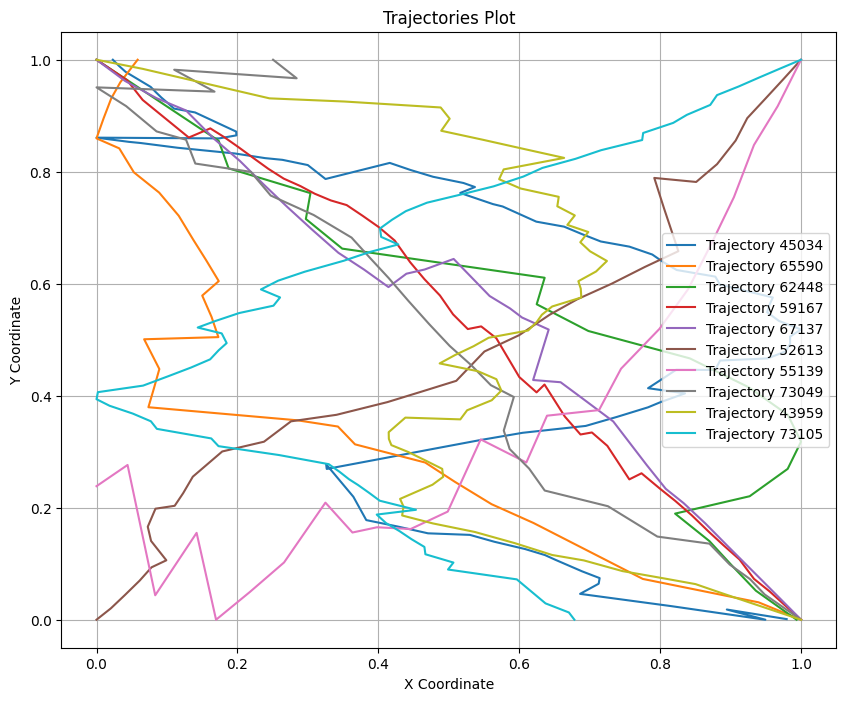

In [9]:
plot_trajectories(all_bird_trajectories_min_max)

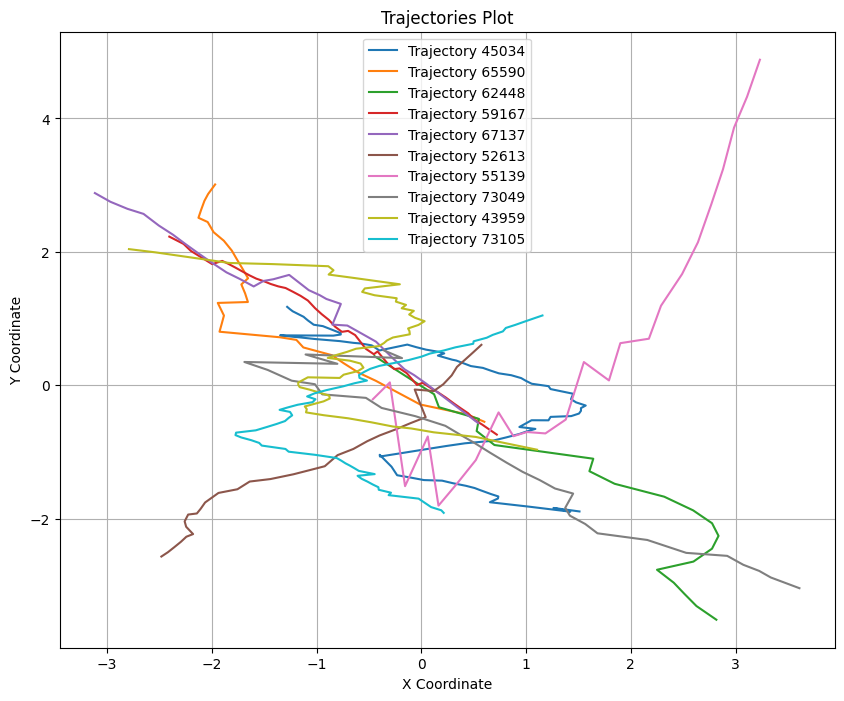

In [10]:
plot_trajectories(all_bird_trajectories_std)

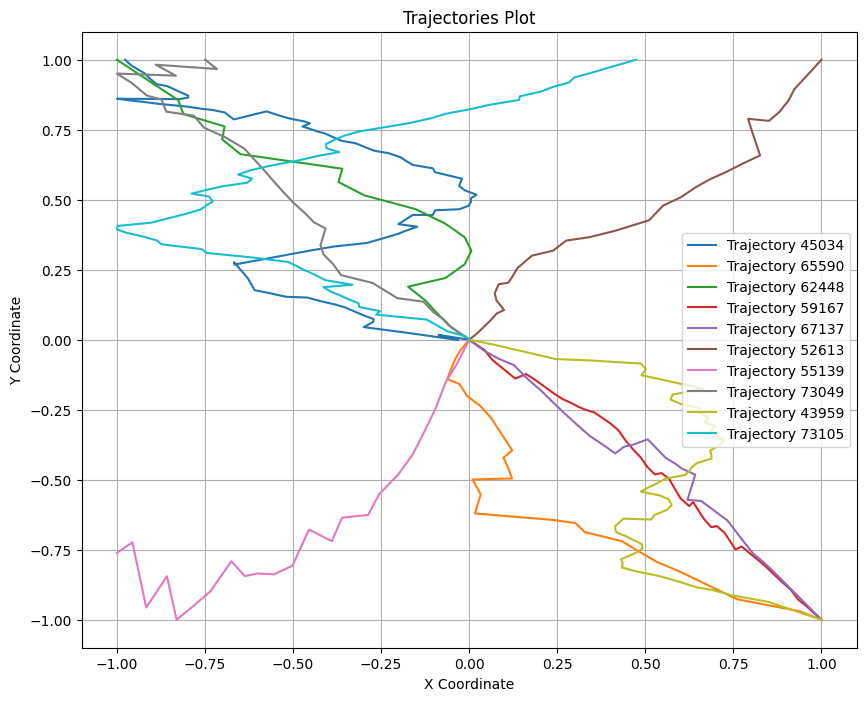

In [11]:
plot_trajectories(all_bird_trajectories_center_max)

In [12]:
base_path_drone = 'Drone'  # Base directory

index_drone = 0
mean_len_list = []

all_drone_trajectories_min_max = pd.DataFrame()
all_drone_trajectories_std = pd.DataFrame()
all_drone_trajectories_center_max = pd.DataFrame()
 
for date_folder in os.listdir(base_path_drone):
    date_folder_path = os.path.join(base_path_drone, date_folder)
    if os.path.isdir(date_folder_path):
        for csv_file in os.listdir(date_folder_path):
            if csv_file.endswith('.csv'):
                file_path = os.path.join(date_folder_path, csv_file)
                temp_df = pd.read_csv(file_path)
                temp_df = temp_df[columns_to_keep]

                if(len(temp_df) < 20): # Si la trayectoria tiene menos de 20 puntos la eliminamos 
                    index_drone = index_drone + 1
                    continue
                
                if(len(temp_df) > fixed_length): # ver cual es el mas largo 
                    temp_df = temp_df.iloc[:fixed_length]
                elif (len(temp_df) < fixed_length):
                    pad_length = fixed_length - len(temp_df)
                    if pad_length > 0:
                        last_row = temp_df.iloc[-1:]
                        padding = pd.concat([last_row] * pad_length, ignore_index=True)
                        temp_df = pd.concat([temp_df, padding], ignore_index=True)
                    
                temp_df['label'] = 0
                                               
                mean_len_list.append(len(temp_df))

                # Apply the min max normalization 
                norm_x = Min_max_normalization(temp_df['DeviceCoordinate1'])
                norm_y  = Min_max_normalization(temp_df['DeviceCoordinate2'])
                temp_df['DeviceCoordinate1'] = norm_x
                temp_df['DeviceCoordinate2'] = norm_y

                all_drone_trajectories_min_max = pd.concat([all_drone_trajectories_min_max, temp_df], ignore_index=True)

                # Apply standard normalization 
                norm_x = std_normalization(temp_df['DeviceCoordinate1'])
                norm_y  = std_normalization(temp_df['DeviceCoordinate2'])
                temp_df['DeviceCoordinate1'] = norm_x
                temp_df['DeviceCoordinate2'] = norm_y

                all_drone_trajectories_std = pd.concat([all_drone_trajectories_std, temp_df], ignore_index=True)

                # Apply center-max normalization 
                norm_x = center_max_normalization(temp_df['DeviceCoordinate1'])
                norm_y  = center_max_normalization(temp_df['DeviceCoordinate2'])
                temp_df['DeviceCoordinate1'] = norm_x
                temp_df['DeviceCoordinate2'] = norm_y
                
                all_drone_trajectories_center_max= pd.concat([all_drone_trajectories_center_max, temp_df], ignore_index=True)



display(all_drone_trajectories_min_max)

print(f'Number of csv skipped: {index_drone}')

print(f'Number of max len: {np.mean(mean_len_list)}')

,ID,DeviceCoordinate1,DeviceCoordinate2,label
0,1961,0.000000,1.000000,0
1,1961,0.009037,0.987607,0
2,1961,0.016878,0.966673,0
3,1961,0.026395,0.945607,0
4,1961,0.034790,0.942697,0
...,...,...,...,...
7695,354,0.000000,0.790898,0
7696,354,0.000000,0.790898,0
7697,354,0.000000,0.790898,0
7698,354,0.000000,0.790898,0


Number of csv skipped: 59
Number of max len: 100.0


In [13]:
display(all_drone_trajectories_std)
#plt.hist(mean_len_list, bins=30)
#print(np.median(mean_len_list))

,ID,DeviceCoordinate1,DeviceCoordinate2,label
0,1961,-1.636183,1.699448,0
1,1961,-1.605332,1.656158,0
2,1961,-1.578562,1.583034,0
3,1961,-1.546072,1.509447,0
4,1961,-1.517412,1.499281,0
...,...,...,...,...
7695,354,-1.475257,0.725079,0
7696,354,-1.475257,0.725079,0
7697,354,-1.475257,0.725079,0
7698,354,-1.475257,0.725079,0


In [14]:
#filtered_drone_trajectories_min_max = all_drone_trajectories_min_max[columns_to_keep]
#filtered_drone_trajectories_std = all_drone_trajectories_std[columns_to_keep]
#filtered_drone_trajectories_center_max = all_drone_trajectories_center_max[columns_to_keep]

display(all_drone_trajectories_center_max)

,ID,DeviceCoordinate1,DeviceCoordinate2,label
0,1961,0.000000,0.000000,0
1,1961,0.009037,-0.012393,0
2,1961,0.016878,-0.033327,0
3,1961,0.026395,-0.054393,0
4,1961,0.034790,-0.057303,0
...,...,...,...,...
7695,354,-1.000000,0.790898,0
7696,354,-1.000000,0.790898,0
7697,354,-1.000000,0.790898,0
7698,354,-1.000000,0.790898,0


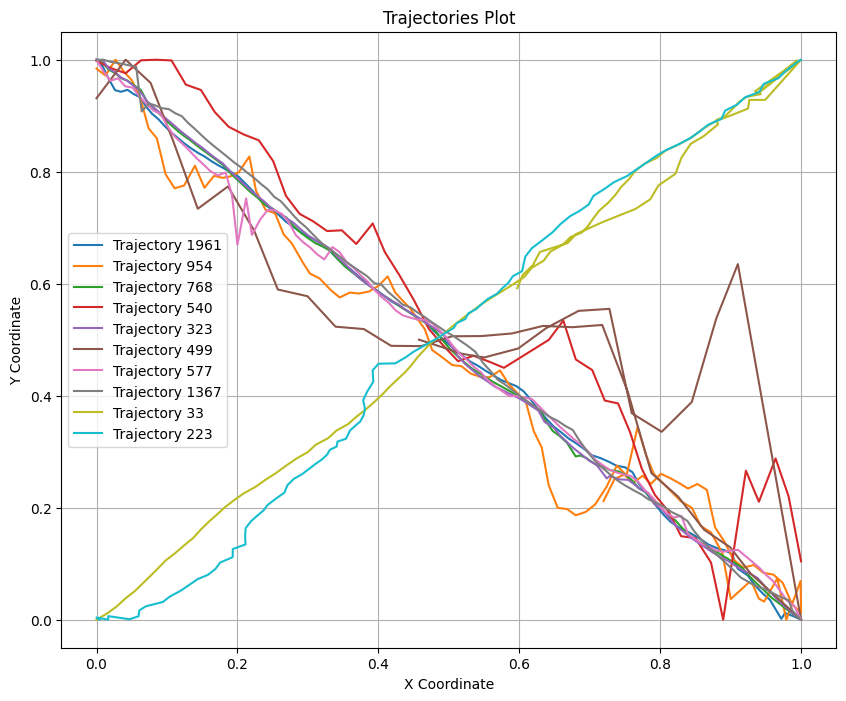

In [15]:
plot_trajectories(all_drone_trajectories_min_max)

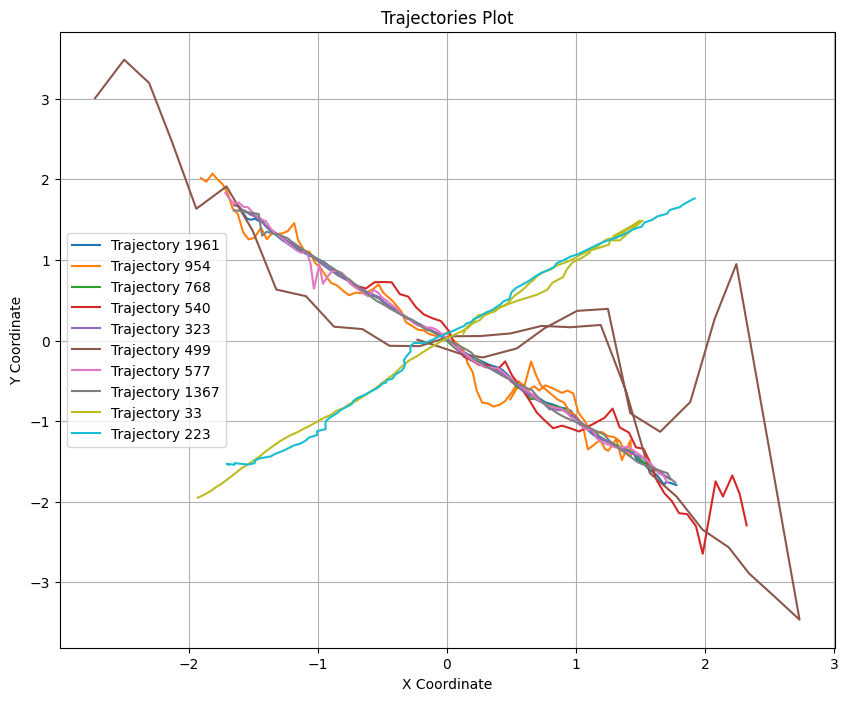

In [16]:
plot_trajectories(all_drone_trajectories_std)

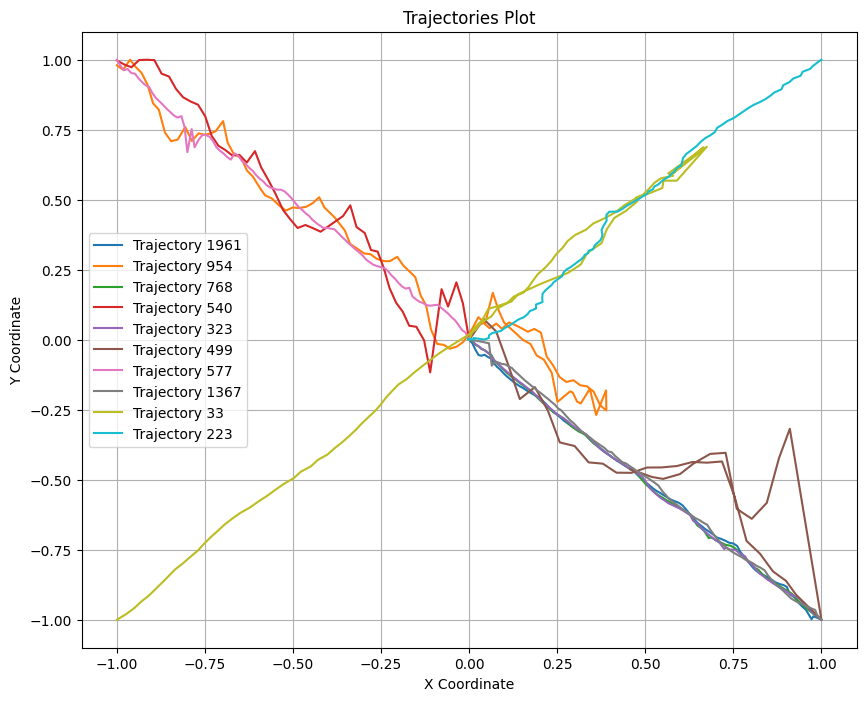

In [17]:
plot_trajectories(all_drone_trajectories_center_max)

In [18]:
#merge both dataframes
merged_trajectories_min_max = pd.concat([all_bird_trajectories_min_max, (all_drone_trajectories_min_max)], ignore_index=True)
merged_trajectories_std = pd.concat([all_bird_trajectories_std, all_drone_trajectories_std], ignore_index=True)
merged_trajectories_center_max = pd.concat([all_bird_trajectories_center_max, all_drone_trajectories_center_max], ignore_index=True)

display(merged_trajectories_min_max)

,ID,DeviceCoordinate1,DeviceCoordinate2,label
0,45034,0.979582,0.001080,1
1,45034,0.894634,0.018211,1
2,45034,0.949366,0.000000,1
3,45034,0.815283,0.024358,1
4,45034,0.750614,0.035294,1
...,...,...,...,...
55695,354,0.000000,0.790898,0
55696,354,0.000000,0.790898,0
55697,354,0.000000,0.790898,0
55698,354,0.000000,0.790898,0


In [19]:
#create training and testing set for minmax
# Split unique trajectory IDs into training and testing sets
unique_ids = merged_trajectories_min_max['ID'].unique()

# Split IDs (70% train, 30% test)
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

# Create training and testing sets based on IDs
train_df = merged_trajectories_min_max[merged_trajectories_min_max['ID'].isin(train_ids)]
test_df = merged_trajectories_min_max[merged_trajectories_min_max['ID'].isin(test_ids)]

# Checking the result
print(f'Minmax Train set size: {len(train_df)}')
print(f'Minmax Test set size: {len(test_df)}')


#create training and testing set for std
# Split unique trajectory IDs into training and testing sets
unique_ids2 = merged_trajectories_std['ID'].unique()

# Split IDs (70% train, 30% test)
train_ids2, test_ids2= train_test_split(unique_ids2, test_size=0.3, random_state=42)

# Create training and testing sets based on IDs
train_df2 = merged_trajectories_std[merged_trajectories_std['ID'].isin(train_ids2)]
test_df2 = merged_trajectories_std[merged_trajectories_std['ID'].isin(test_ids2)]

# Checking the result
print(f'Std Train set size: {len(train_df2)}')
print(f'Std Test set size: {len(test_df2)}')


#create training and testing set for centermax
# Split unique trajectory IDs into training and testing sets
unique_ids3 = merged_trajectories_center_max['ID'].unique()

# Split IDs (70% train, 30% test)
train_ids3, test_ids3 = train_test_split(unique_ids3, test_size=0.3, random_state=42)

# Create training and testing sets based on IDs
train_df3 = merged_trajectories_center_max[merged_trajectories_center_max['ID'].isin(train_ids3)]
test_df3 = merged_trajectories_center_max[merged_trajectories_center_max['ID'].isin(test_ids3)]

# Checking the result
print(f'Centermax Train set size: {len(train_df3)}')
print(f'Centermax Test set size: {len(test_df3)}')



Minmax Train set size: 38700
Minmax Test set size: 17000
Std Train set size: 38700
Std Test set size: 17000
Centermax Train set size: 38700
Centermax Test set size: 17000


Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7708 - loss: 0.5772 - val_accuracy: 0.7344 - val_loss: 0.6917
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8894 - loss: 0.3555 - val_accuracy: 0.7344 - val_loss: 0.6314
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8758 - loss: 0.3773 - val_accuracy: 0.7344 - val_loss: 0.6637
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8662 - loss: 0.3941 - val_accuracy: 0.7344 - val_loss: 0.6384
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8807 - loss: 0.3645 - val_accuracy: 0.7344 - val_loss: 0.6947
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8805 - loss: 0.3634 - val_accuracy: 0.7344 - val_loss: 0.6398
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8646 - loss: 0.4009 - val_accuracy: 0.7344 - val_loss: 0.6182
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8814 - loss: 0.3705 - val_accuracy: 0.7344 - val_loss: 

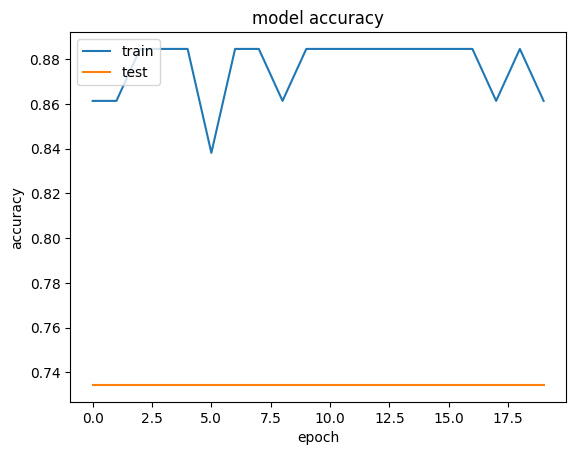

In [33]:
num_features = 2  # 'DeviceCoordinate1' and 'DeviceCoordinate2'

# Preparing data for LSTM Minmax normalization 
X_train = train_df[['DeviceCoordinate1', 'DeviceCoordinate2']].values.reshape(-1, 100, num_features)
y_train = train_df['label'].values[::100]  # Assuming label is same for all rows in a trajectory

X_test = test_df[['DeviceCoordinate1', 'DeviceCoordinate2']].values.reshape(-1, 100, num_features)
y_test = test_df['label'].values[::100]

# Building the LSTM model
model = Sequential([
    LSTM(100, input_shape=(100, num_features), return_sequences=True),
    Dropout(0.5),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.7675 - loss: 0.6184 - val_accuracy: 0.7344 - val_loss: 0.5911
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8753 - loss: 0.3986 - val_accuracy: 0.7344 - val_loss: 0.6455
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8754 - loss: 0.3971 - val_accuracy: 0.7344 - val_loss: 0.6568
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8983 - loss: 0.3346 - val_accuracy: 0.7344 - val_loss: 0.6202
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8606 - loss: 0.4052 - val_accuracy: 0.7344 - val_loss: 0.6387
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8705 - loss: 0.3868 - val_accuracy: 0.7344 - val_loss: 0.6224
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8762 - loss: 0.3864 - val_accuracy: 0.7344 - val_loss: 0.6010
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8732 - loss: 0.3774 - val_accuracy: 0.7344 - val_loss:

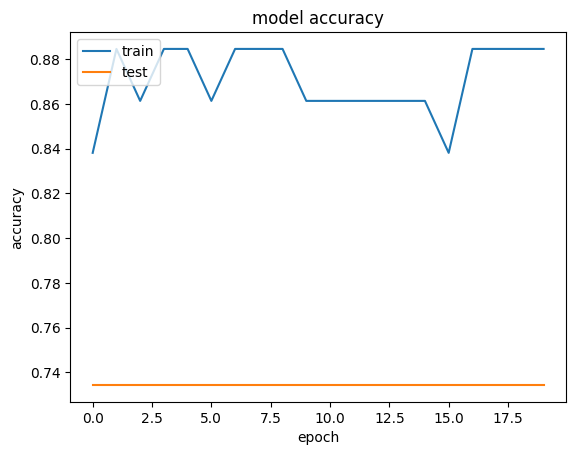

In [28]:
# Preparing data for LSTM Std normalization 
X_train2 = train_df2[['DeviceCoordinate1', 'DeviceCoordinate2']].values.reshape(-1, 100, num_features)
y_train2 = train_df2['label'].values[::100]  # Assuming label is same for all rows in a trajectory

X_test2 = test_df2[['DeviceCoordinate1', 'DeviceCoordinate2']].values.reshape(-1, 100, num_features)
y_test2 = test_df2['label'].values[::100]

# Building the LSTM model
model2 = Sequential([
    LSTM(100, input_shape=(100, num_features), return_sequences=True),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
optimize2 = Adam(learning_rate=0.0001)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train2, y_train2, epochs=20, batch_size=32, validation_data=(X_test2, y_test2))

# Evaluate the model
loss2, accuracy2 = model2.evaluate(X_test2, y_test2)
print(f'Test Loss: {loss2}, Test Accuracy: {accuracy2}')

history2 = model2.fit(X_train2, y_train2, epochs=20, batch_size=32, validation_data=(X_test2, y_test2))

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.7866 - loss: 0.6001 - val_accuracy: 0.7344 - val_loss: 0.6305
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9076 - loss: 0.3254 - val_accuracy: 0.7344 - val_loss: 0.7169
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8469 - loss: 0.4489 - val_accuracy: 0.7344 - val_loss: 0.6533
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8796 - loss: 0.3673 - val_accuracy: 0.7344 - val_loss: 0.6678
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8947 - loss: 0.3378 - val_accuracy: 0.7344 - val_loss: 0.6540
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8760 - loss: 0.3758 - val_accuracy: 0.7344 - val_loss: 0.6351
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8698 - loss: 0.3841 - val_accuracy: 0.7344 - val_loss: 0.6465
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8895 - loss: 0.3584 - val_accuracy: 0.7344 - val_loss:

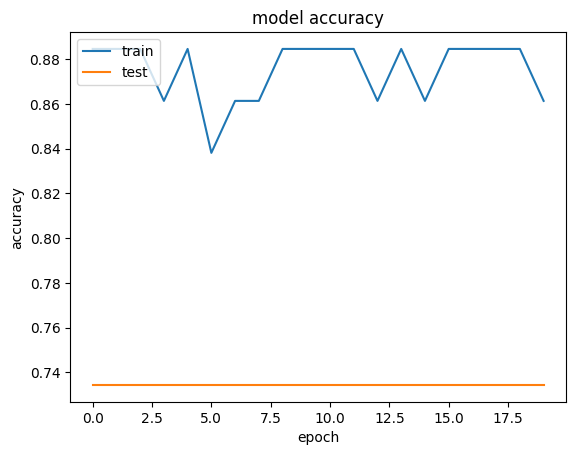

In [34]:
# Preparing data for LSTM Center max normalization 
X_train3 = train_df3[['DeviceCoordinate1', 'DeviceCoordinate2']].values.reshape(-1, 100, num_features)
y_train3 = train_df3['label'].values[::100]  # Assuming label is same for all rows in a trajectory

X_test3 = test_df3[['DeviceCoordinate1', 'DeviceCoordinate2']].values.reshape(-1, 100, num_features)
y_test3 = test_df3['label'].values[::100]

model3 = Sequential([
    LSTM(100, input_shape=(100, num_features), return_sequences=True),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
optimize3 = Adam(learning_rate=0.0001)
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model3.fit(X_train3, y_train3, epochs=20, batch_size=32, validation_data=(X_test3, y_test3))

# Evaluate the model
loss3, accuracy3 = model3.evaluate(X_test3, y_test3)
print(f'Test Loss: {loss3}, Test Accuracy: {accuracy3}')

history3 = model3.fit(X_train3, y_train3, epochs=20, batch_size=32, validation_data=(X_test3, y_test3))

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


layers=[8, 8, 8, 1], train_examples=387, test_examples=170
batch = 387, timesteps = 100, features = 2, epochs = 10
learning_rate = 0.02, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 100, 8)            │        352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_15          │ (None, 100, 8)            │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_34 (LSTM)                  │ (None, 100, 8)            │        544 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_16          │ (None, 100, 8)            │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_35 (LSTM)                  │ (None, 8)                 │        544 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_17          │ (None, 8)                 │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 1)                 │          9 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,545 (6.04 KB)

 Trainable params: 1,497 (5.85 KB)

 Non-trainable params: 48 (192.00 B)

None
Restoring model weights from the end of the best epoch: 1.
-----------------------------------------------------------------
Training was completed in 3.73 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 87.5969%
test accuracy = 82.9412%
test error = 29 out of 170 examples


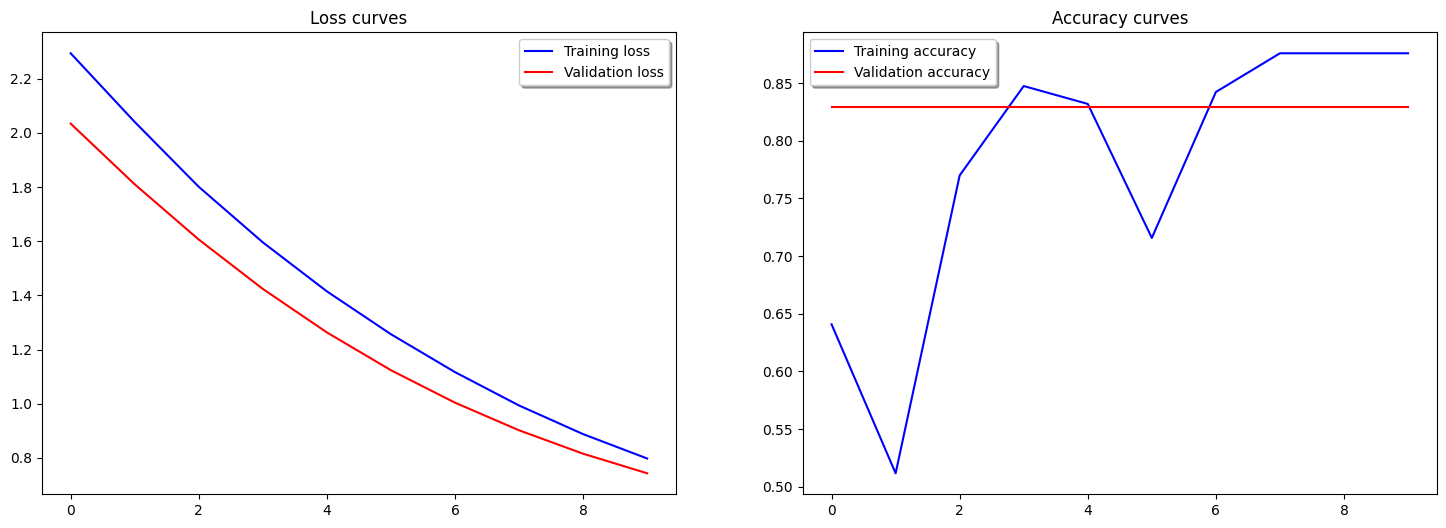

In [31]:
num_features = 2  # 'DeviceCoordinate1' and 'DeviceCoordinate2'
T=100

# Preparing data for LSTM: train_df -> MinMax normalization, train_df2 -> Std normalization, train_df3 -> Center-max normalization 
X_train3 = train_df3[['DeviceCoordinate1', 'DeviceCoordinate2']].values.reshape(-1, 100, num_features)
y_train3 = train_df3['label'].values[::100]  # Assuming label is same for all rows in a trajectory

X_test3 = test_df3[['DeviceCoordinate1', 'DeviceCoordinate2']].values.reshape(-1, 100, num_features)
y_test3 = test_df3['label'].values[::100]

#Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train3.shape[0]           # number of training examples (2D)
M_TEST = X_test3.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train3.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 2e-2                           # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'learning_rate = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=30, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train3, y_train3,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_test3[:M_TEST], y_test3[:M_TEST]),
                    shuffle=True,verbose=0,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train3, y_train3,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test3[:M_TEST], y_test3[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

# MinMax Scaler normalization 

In [ ]:
x_series = Series(x)
y_series = Series(y)

x_values = x_series.values
x_values = x_values.reshape((len(x_values), 1))

y_values = y_series.values
y_values = y_values.reshape((len(y_values), 1))

x_scaler = MinMaxScaler(feature_range=(0,1))
x_scaler = x_scaler.fit(x_values)

y_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = y_scaler.fit(y_values)

x_normalized = x_scaler.transform(x_values)
y_normalized = y_scaler.transform(y_values)

print(x_normalized)
print(y_normalized)



NameError: name 'x' is not defined

In [ ]:
fig4 = plt.figure(figsize = (10,10))
ax4 = plt.axes()

ax4.plot(x,y)
ax4.scatter(x,y)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_title('X-Y trajectoery')
plt.show()

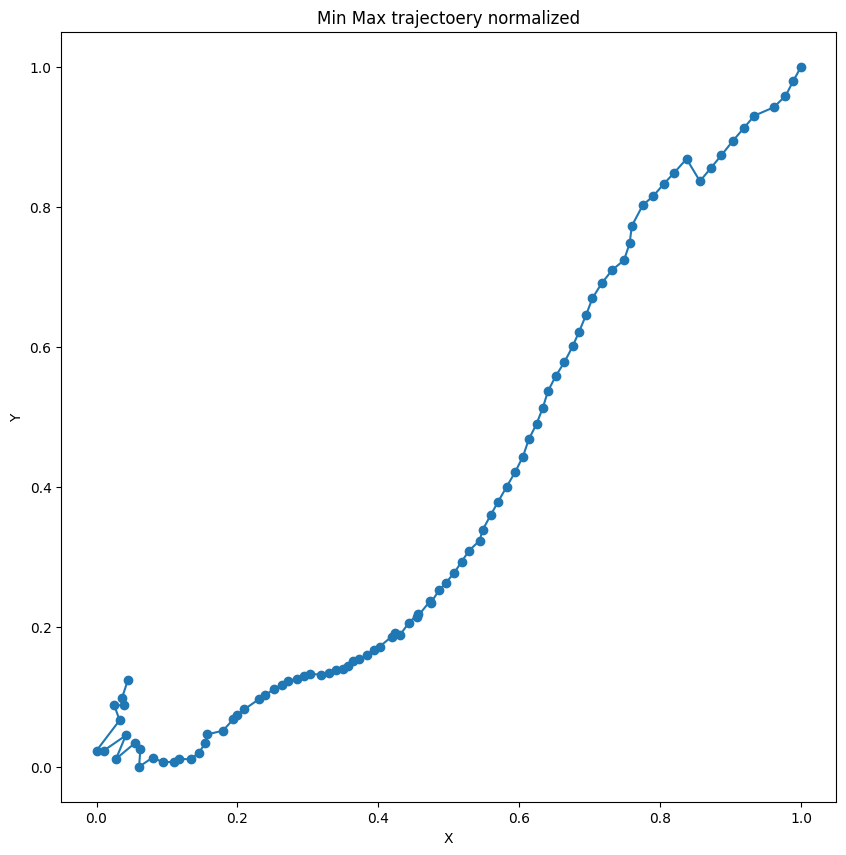

In [ ]:
fig3 = plt.figure(figsize = (10,10))
ax3 = plt.axes()

ax3.plot(x_normalized,y_normalized)
ax3.scatter(x_normalized,y_normalized)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title('Min Max trajectoery normalized')
plt.show()

# Standard scaler normalization 

In [ ]:
x_series_std = Series(x)
y_series_std = Series(y)

x_values_std = x_series_std.values
y_values_std = y_series_std.values

x_values_std = x_values_std.reshape((len(x_values_std), 1))
y_values_std = y_values_std.reshape((len(y_values_std), 1))

x_scaler_std = StandardScaler()
y_scaler_std = StandardScaler()

x_scaler_std = x_scaler_std.fit(x_values_std)
y_scaler_std = y_scaler_std.fit(y_values_std)

print('Mean X: %f, StandardDeviation: %f' % (x_scaler_std.mean_, sqrt(x_scaler_std.var_)))

print('Mean Y: %f, StandardDeviation: %f' % (y_scaler_std.mean_, sqrt(y_scaler_std.var_)))
# normalize the dataset and print
x_standardized = x_scaler_std.transform(x_values_std)
y_standardized = y_scaler_std.transform(y_values_std)
print(x_standardized)
print(y_standardized)
# inverse transform and print
# inversed = scaler.inverse_transform(standardized)
# print(inversed)

Mean X: 718.229170, StandardDeviation: 264.888890
Mean Y: 1647.405826, StandardDeviation: 243.706033
[[ 1.91540543]
 [ 1.87757599]
 [ 1.83801426]
 [ 1.77874396]
 [ 1.68321202]
 [ 1.6305787 ]
 [ 1.57804595]
 [ 1.51875768]
 [ 1.46623394]
 [ 1.41257661]
 [ 1.3460208 ]
 [ 1.28183825]
 [ 1.23338566]
 [ 1.180633  ]
 [ 1.12883747]
 [ 1.07375293]
 [ 1.06316943]
 [ 1.035149  ]
 [ 0.97562304]
 [ 0.9237817 ]
 [ 0.87814562]
 [ 0.84692162]
 [ 0.81093413]
 [ 0.77926552]
 [ 0.73900621]
 [ 0.69604344]
 [ 0.65712525]
 [ 0.63154177]
 [ 0.60007586]
 [ 0.56173974]
 [ 0.53223378]
 [ 0.49505053]
 [ 0.45122629]
 [ 0.40899373]
 [ 0.37169274]
 [ 0.33214887]
 [ 0.3171516 ]
 [ 0.26384274]
 [ 0.2271965 ]
 [ 0.19091681]
 [ 0.15063852]
 [ 0.11521023]
 [ 0.07480803]
 [ 0.07212789]
 [ 0.00699227]
 [ 0.01213675]
 [-0.03427803]
 [-0.07909969]
 [-0.10555694]
 [-0.12031102]
 [-0.1792237 ]
 [-0.21065428]
 [-0.24322656]
 [-0.28397202]
 [-0.3118674 ]
 [-0.3380294 ]
 [-0.36442504]
 [-0.39734929]
 [-0.43428192]
 [-0.47268361]

/var/folders/v9/jdh_sf0s6059j5bw53rnglhr0000gn/T/ipykernel_13603/2231136016.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Mean X: %f, StandardDeviation: %f' % (x_scaler_std.mean_, sqrt(x_scaler_std.var_)))
/var/folders/v9/jdh_sf0s6059j5bw53rnglhr0000gn/T/ipykernel_13603/2231136016.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Mean Y: %f, StandardDeviation: %f' % (y_scaler_std.mean_, sqrt(y_scaler_std.var_)))


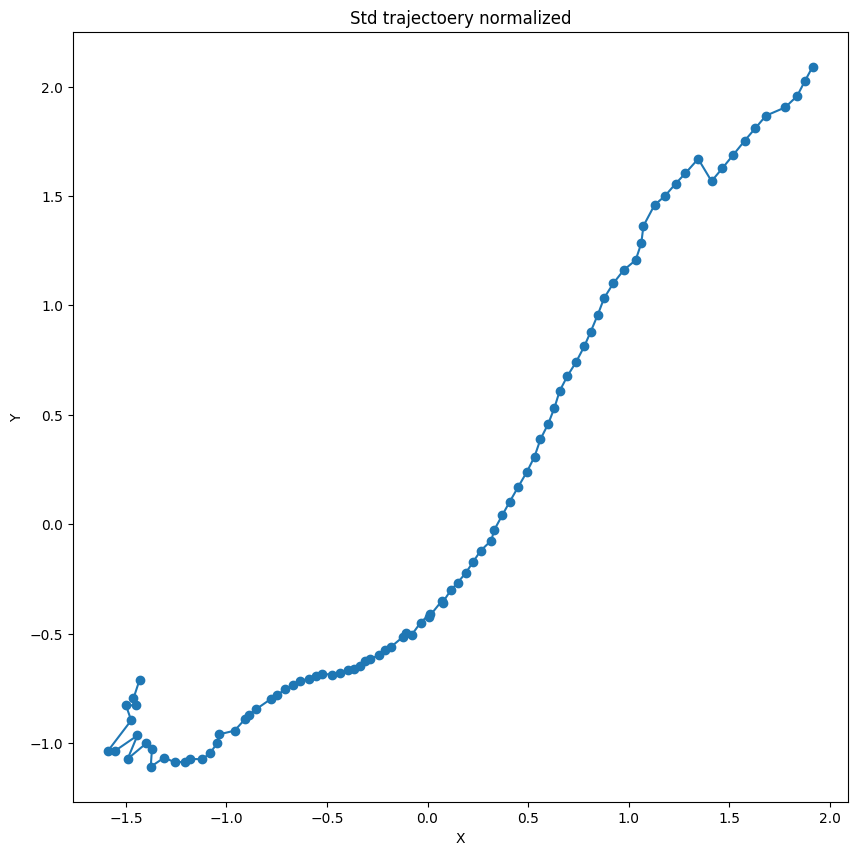

In [ ]:
fig2 = plt.figure(figsize = (10,10))
ax2 = plt.axes()

ax2.plot(x_standardized,y_standardized)
ax2.scatter(x_standardized,y_standardized)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Std trajectoery normalized')
plt.show()

# Center max normalization 

In [ ]:
x_series_center_max = Series(x)
y_series_center_max = Series(y)

x_values_center_max = x_series_center_max.values
y_values_center_max = y_series_center_max.values

# print(y_values_center_max)

# Apply the center max normalization to x values 
x_normalized_data_center_max = np.empty(x_values_center_max.shape)
x_1 = x_values_center_max[0]
dmax_x = np.max(np.abs(x_values_center_max-x_1))
for i in range(len(x_series_center_max)): 
    x_normalized_data_center_max[i] = center_max_normalization(x_values_center_max[i],x_1,dmax_x)

print(x_normalized_data_center_max)

y_normalized_data_center_max = np.empty(y_values_center_max.shape)
y_1 = y_values_center_max[0]
dmax_y = np.max(np.abs(y_values_center_max-y_1))
for i in range(len(y_series_center_max)): 
    y_normalized_data_center_max[i] = center_max_normalization(y_values_center_max[i],y_1,dmax_y)

print(y_normalized_data_center_max)



[ 0.         -0.01079737 -0.02208918 -0.03900626 -0.06627323 -0.08129596
 -0.09628999 -0.1132122  -0.12820366 -0.14351867 -0.1625152  -0.18083434
 -0.1946638  -0.2097206  -0.22450421 -0.24022658 -0.24324735 -0.25124501
 -0.26823506 -0.28303174 -0.29605731 -0.30496934 -0.31524098 -0.32427992
 -0.33577083 -0.34803337 -0.3591415  -0.3664436  -0.37542468 -0.38636667
 -0.39478834 -0.40540128 -0.4179097  -0.42996382 -0.44061037 -0.45189708
 -0.45617764 -0.47139319 -0.48185285 -0.49220789 -0.50370422 -0.51381625
 -0.52534795 -0.52611292 -0.5447041  -0.54323575 -0.55648357 -0.56927668
 -0.57682817 -0.58103932 -0.59785433 -0.60682532 -0.61612218 -0.62775186
 -0.63571383 -0.64318105 -0.65071496 -0.66011228 -0.67065369 -0.68161439
 -0.69631213 -0.70515342 -0.7147204  -0.72816245 -0.73735468 -0.74868788
 -0.76083896 -0.76953197 -0.79004467 -0.80016333 -0.80603316 -0.82046971
 -0.84263427 -0.84557342 -0.85480509 -0.86629923 -0.88326416 -0.89045509
 -0.90566409 -0.92019208 -0.9395166  -0.93783873 -0

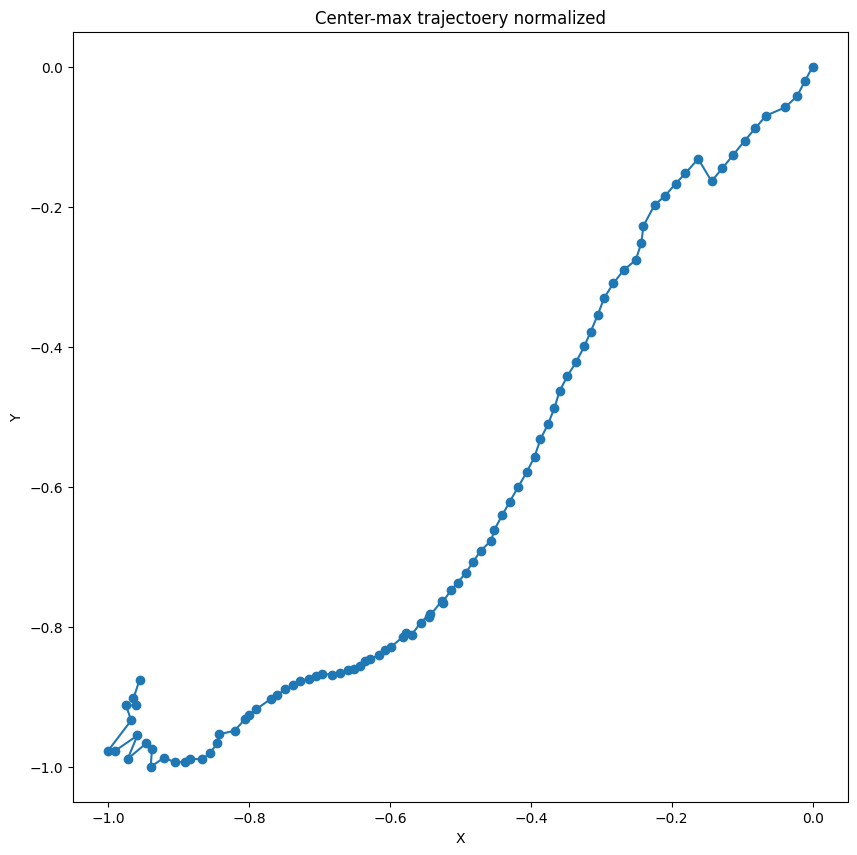

In [ ]:
fig5 = plt.figure(figsize = (10,10))
ax5 = plt.axes()

ax5.plot(x_normalized_data_center_max,y_normalized_data_center_max)
ax5.scatter(x_normalized_data_center_max,y_normalized_data_center_max)

ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_title('Center-max trajectoery normalized')
plt.show()